In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
import train

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 10)

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [3]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t4_data/{key}.pkl')
    return raw[key]

In [4]:
configurations = {
    'dataset' : 'sample_', # '', 'sample_', 'secret_'
    'model_identifier' : "all_small_2",
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t4_models",
    'train_params' : {
        'batch_size': 50000,
        'shuffle': True,
        'num_workers': 3,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 2,
        'pin_memory': True,
    },
}

In [5]:
%%time

train_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=False))
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=True))

train_df = train_df.dropna()
test_df = test_df.dropna()
# train_df = train_df.sample(100000, random_state=42)
# test_df = test_df.sample(10000, random_state=42)

Loading data to cache for: sample_train
Loading data to cache for: sample_test
CPU times: user 735 ms, sys: 640 ms, total: 1.38 s
Wall time: 1.09 s


In [6]:
ref_train, X_train, y_train = get_ref_X_y(train_df)
ref_test, X_test, y_test = get_ref_X_y(test_df)

In [7]:
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_RA_OF_ASC_NODE', 'y_ARG_OF_PERICENTER_REG', 'y_ARG_OF_PERICENTER', 'y_BSTAR', 'y_REV_MA_REG', 'y_MEAN_ANOMALY']
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG']
# y_cols = ['y_REV_MA_REG']
y_train = y_train[y_cols]
y_test = y_test[y_cols]

# y_train = np.sign(y_train) * np.log(1+np.abs(y_train))
# y_test = np.sign(y_test) * np.log(1+np.abs(y_test))

In [8]:
# model, mean_losses = train.train_model(X_train, y_train, X_test, y_test, configurations, force_train=False)

Loading existing model


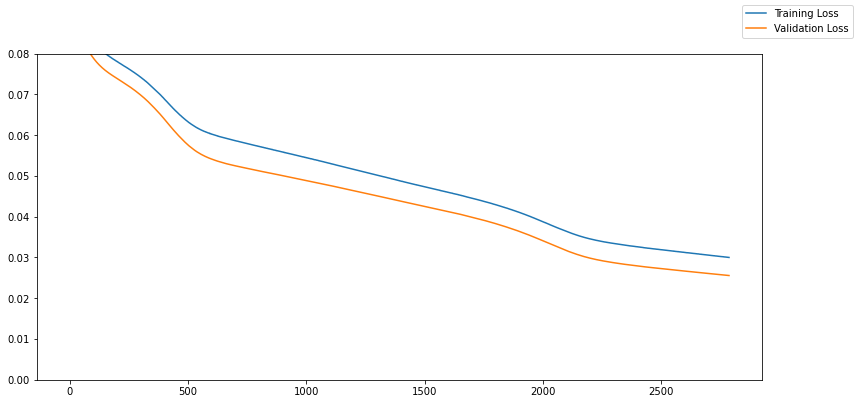

In [68]:
model, _, _, mean_losses, _ = train.load_model_with_config(configurations)

tl, vl = zip(*mean_losses)

fig,ax = plt.subplots(figsize=(13,6))
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")
plt.ylim(0, 0.08)
fig.legend()
plt.show()

In [69]:
mean_losses[-50:]

[(0.03033359271163742, 0.02585792914032936),
 (0.030313524417579174, 0.025852994993329048),
 (0.030319692411770422, 0.025847269222140312),
 (0.030312092198679846, 0.025841088965535164),
 (0.030302091501653194, 0.02583630383014679),
 (0.030297184828668833, 0.025829432532191277),
 (0.03029307210817933, 0.025823889300227165),
 (0.03028021116430561, 0.02581852674484253),
 (0.030290619780619938, 0.025812778621912003),
 (0.030275048377613228, 0.02580586075782776),
 (0.030262896946320932, 0.025801941752433777),
 (0.03026854262376825, 0.025795618072152138),
 (0.03024912935992082, 0.025788793340325356),
 (0.03024427794540922, 0.02578456699848175),
 (0.030235177061210077, 0.025777412578463554),
 (0.030231324024498463, 0.02577371709048748),
 (0.030240817461162806, 0.025766760110855103),
 (0.030217866102854412, 0.02576018124818802),
 (0.030215688981115818, 0.02575492300093174),
 (0.030211653870840866, 0.025749778375029564),
 (0.030213376662383478, 0.02574346214532852),
 (0.03020022079969446, 0.025

In [67]:
trained_model = model
sample_idx = random.sample(list(X_test.index), 10000)

X_sample = X_test.loc[sample_idx]
y_sample = y_test.loc[sample_idx]
# y_train_pred = train.predict(trained_model, X_train, y_train, device="cpu") # get predictions for each train
# y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe
y_sample_pred = train.predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe

In [65]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')

# random.seed(342798)
sample = random.sample(list(y_sample_pred_df.index), 10)
# sample = [0,1]

print("Test - Ground Truth (normalized):")
display(y_sample)
print("Test - Prediction (normalized):")
display(y_sample_pred_df)
# print("Ground Truth Diffs from X_:")
# display(y_sample - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)
# print("Pred Diffs from X_:")
# display(y_sample_pred_df - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)


    Test set MAE (L1) loss: 0.08784185061738027
    Test set MSE (L2) loss: 0.025756175228830572
Test - Ground Truth (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
74187,0.5403388889,0.0507664,0.4256806309,0.8173355556,0.4127777778,0.7509957994
57042,0.5501438889,0.0643800,0.3676348880,0.6494483333,0.6525513889,0.9593729105
18362,0.3690805556,0.1148700,0.3518580503,0.2851758333,0.8377452778,0.8350539259
31783,0.3690388889,0.1051672,0.3609027703,0.3732377778,0.5854444444,1.0156724352
44454,0.5503188889,0.0719116,0.3588668423,0.3207311111,0.9089802778,0.1565363642
...,...,...,...,...,...,...
47824,0.5498088889,0.0697756,0.3613826137,0.1049061111,0.6510086111,0.4704975648
22722,0.3691794444,0.1366708,0.3309224743,0.7702675000,0.5247622222,0.7385980062
2170,0.3690788889,0.2045068,0.2755021371,0.1714575000,0.9478208333,0.4449717099
47359,0.5497672222,0.0709888,0.3595883474,0.9709205556,0.6881341667,0.4034105340


Test - Prediction (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
74187,0.5349220634,0.0323958769,0.4293343127,0.6932772398,0.4946529567,0.8716166019
57042,0.5453032255,0.0816151127,0.3634023666,0.6362135410,0.5063600540,0.6201730967
18362,0.3641768992,0.1193050891,0.3428828120,0.2354363203,0.9018160701,0.4724469185
31783,0.3691449761,0.1191128567,0.3541151285,0.3813172579,0.6158822775,0.7245007753
44454,0.5479738116,0.0145360194,0.3821706772,0.6137387156,0.6081430912,0.4084791839
...,...,...,...,...,...,...
47824,0.5472965837,0.0368772000,0.3735037446,0.2670060396,0.4167818427,0.6476712227
22722,0.3646118641,0.1296092570,0.3345108330,0.7392506599,0.5533443093,0.7906768322
2170,0.3665192425,0.1766291857,0.2842431664,0.3248595595,0.6737453938,0.3689351678
47359,0.5433495641,0.0345828757,0.3757683337,0.7285017371,1.0740083456,0.6145985126
